In [160]:
import numpy as np
import pandas as pd
import plotly.express as px
from darts.metrics.metrics import r2_score, smape, mae, mape
from darts.dataprocessing.transformers.scaler import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.models import RNNModel, LightGBMModel
from darts.timeseries import TimeSeries

In [161]:
raw_data = pd.read_csv('site_id_1.csv', parse_dates=['timestamp'])

In [162]:
raw_data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,4154.2543,3.8,NaN,2.4,1020.9,240.0,3.1
1,2016-01-01 01:00:00,8337.2696,3.7,0.0,2.4,1021.6,230.0,2.6
2,2016-01-01 02:00:00,8317.9158,2.6,0.0,1.9,1021.9,0.0,0.0
3,2016-01-01 03:00:00,8392.4680,2.0,0.0,1.2,1022.3,170.0,1.5
4,2016-01-01 04:00:00,8109.9117,2.3,0.0,1.8,1022.7,110.0,1.5


In [163]:
#Check for missing timesteps
def is_missing_timesteps(df, date_col = 'date', freq='1H'):
    index_series  = pd.date_range(start=df[date_col][df.index[0]], end=df[date_col][df.index[-1]], freq=freq)
    return not index_series.equals(pd.Index(pd.to_datetime(df[date_col])))

In [164]:
is_missing_timesteps(raw_data, date_col='timestamp')

False

In [165]:
#So, the dataframe is missing some datetime steps, Let's extract missing timesteps
def get_missing_timesteps(df, date_col ='date', freq='H'):
    index_series = pd.date_range(start=df[date_col][df.index[0]], end=df[date_col][df.index[-1]], freq=freq)
    df_index = pd.Index(pd.to_datetime(df[date_col]))
    return index_series.difference(df_index)

In [166]:
get_missing_timesteps(raw_data, date_col='timestamp')

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [167]:
raw_data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,4154.2543,3.8,NaN,2.4,1020.9,240.0,3.1
1,2016-01-01 01:00:00,8337.2696,3.7,0.0,2.4,1021.6,230.0,2.6
2,2016-01-01 02:00:00,8317.9158,2.6,0.0,1.9,1021.9,0.0,0.0
3,2016-01-01 03:00:00,8392.4680,2.0,0.0,1.2,1022.3,170.0,1.5
4,2016-01-01 04:00:00,8109.9117,2.3,0.0,1.8,1022.7,110.0,1.5


In [168]:
raw_data.isnull().mean()

timestamp             0.000000
meter_reading         0.000000
air_temperature       0.002505
cloud_coverage        0.806352
dew_temperature       0.002505
sea_level_pressure    0.008311
wind_direction        0.002732
wind_speed            0.002391
dtype: float64

In [169]:
raw_data['air_temperature'] = raw_data['air_temperature'].interpolate()
raw_data['cloud_coverage'] = raw_data['cloud_coverage'].fillna(0)
raw_data['dew_temperature'] = raw_data['dew_temperature'].interpolate()
raw_data['sea_level_pressure'] = raw_data['sea_level_pressure'].interpolate()
raw_data['wind_direction'] = raw_data['wind_direction'].interpolate()
raw_data['wind_speed'] = raw_data['wind_speed'].interpolate()

In [170]:
#Adding windows statsitics
raw_data['rolling mean'] = raw_data['meter_reading'].rolling(window=10, min_periods=0).apply(lambda x: sum(x[:-1]))
raw_data['rolling std'] = raw_data['meter_reading'].rolling(window=10, min_periods=0, closed='left').apply(lambda x: np.std(x[:-1]))
raw_data['diff'] = raw_data['meter_reading'].shift(1) - raw_data['meter_reading'].shift(2)
raw_data.fillna(0, inplace=True)

In [171]:
raw_data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed,rolling mean,rolling std,diff
0,2016-01-01 00:00:00,4154.2543,3.8,0.0,2.4,1020.9,240.0,3.1,0.0000,0.000000,0.0000
1,2016-01-01 01:00:00,8337.2696,3.7,0.0,2.4,1021.6,230.0,2.6,4154.2543,0.000000,0.0000
2,2016-01-01 02:00:00,8317.9158,2.6,0.0,1.9,1021.9,0.0,0.0,12491.5239,0.000000,4183.0153
3,2016-01-01 03:00:00,8392.4680,2.0,0.0,1.2,1022.3,170.0,1.5,20809.4397,2091.507650,-19.3538
4,2016-01-01 04:00:00,8109.9117,2.3,0.0,1.8,1022.7,110.0,1.5,29201.9077,1967.346455,74.5522


In [172]:
raw_data.isnull().mean()

timestamp             0.0
meter_reading         0.0
air_temperature       0.0
cloud_coverage        0.0
dew_temperature       0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
rolling mean          0.0
rolling std           0.0
diff                  0.0
dtype: float64

In [173]:
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

settings = ComprehensiveFCParameters()
raw_data_with_features = extract_features(raw_data[['air_temperature', 'meter_reading', 'timestamp']], column_id='timestamp', default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 20/20 [04:26<00:00, 13.31s/it]


In [174]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.feature_selection import VarianceThreshold
impute(raw_data_with_features)

VT_feat = VarianceThreshold(threshold=0.05)

raw_data_with_relevant_features = VT_feat.fit_transform(raw_data_with_features)

/Users/sharabhshuklaair/opt/anaconda3/envs/armts/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning:

The columns ['meter_reading__mean_abs_change' 'meter_reading__mean_change'
 'meter_reading__mean_second_derivative_central' ...
 'air_temperature__matrix_profile__feature_"25"__threshold_0.98'
 'air_temperature__matrix_profile__feature_"75"__threshold_0.98'
 'air_temperature__mean_n_absolute_max__number_of_maxima_7'] did not have any finite values. Filling with zeros.



In [175]:
raw_data_with_relevant_features = pd.DataFrame(raw_data_with_relevant_features)

In [176]:
raw_data_with_relevant_features.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,4154.2543,1.725783e+07,4154.2543,4154.2543,4154.2543,4154.2543,4154.2543,4154.2543,-0.064614,4154.2543,...,3.8,3.8,3.8,2.330507,1.473942,1.042235,0.736971,3.8,3.8,0.0
1,8337.2696,6.951006e+07,8337.2696,8337.2696,8337.2696,8337.2696,8337.2696,8337.2696,-0.272809,8337.2696,...,3.7,3.7,3.7,2.269178,1.435154,1.014807,0.717577,3.7,3.7,0.0
2,8317.9158,6.918772e+07,8317.9158,8317.9158,8317.9158,8317.9158,8317.9158,8317.9158,-0.272809,8317.9158,...,2.6,2.6,2.6,1.594558,1.008487,0.713108,0.504243,2.6,2.6,0.0
3,8392.4680,7.043352e+07,8392.4680,8392.4680,8392.4680,8392.4680,8392.4680,8392.4680,-0.272809,8392.4680,...,2.0,2.0,2.0,1.226583,0.775759,0.548545,0.387880,2.0,2.0,0.0
4,8109.9117,6.577067e+07,8109.9117,8109.9117,8109.9117,8109.9117,8109.9117,8109.9117,-0.272809,8109.9117,...,2.3,2.3,2.3,1.410570,0.892123,0.630826,0.446061,2.3,2.3,0.0


In [177]:
#Drop highly correlated features
# Create correlation matrix
corr_matrix = raw_data_with_relevant_features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]


/var/folders/4r/07hppdbs6sq9pnrjshv2sl3m0000gn/T/ipykernel_8576/719271283.py:6: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [178]:
raw_data_with_relevant_features.drop(columns=to_drop, axis=1, inplace=True)

In [179]:
raw_data = pd.concat([raw_data, raw_data_with_relevant_features], axis=1)
raw_data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed,rolling mean,rolling std,diff,0,8,23,31,46
0,2016-01-01 00:00:00,4154.2543,3.8,0.0,2.4,1020.9,240.0,3.1,0.0000,0.000000,0.0000,4154.2543,-0.064614,3.8,0.062915,0.0
1,2016-01-01 01:00:00,8337.2696,3.7,0.0,2.4,1021.6,230.0,2.6,4154.2543,0.000000,0.0000,8337.2696,-0.272809,3.7,0.062915,0.0
2,2016-01-01 02:00:00,8317.9158,2.6,0.0,1.9,1021.9,0.0,0.0,12491.5239,0.000000,4183.0153,8317.9158,-0.272809,2.6,0.295657,0.0
3,2016-01-01 03:00:00,8392.4680,2.0,0.0,1.2,1022.3,170.0,1.5,20809.4397,2091.507650,-19.3538,8392.4680,-0.272809,2.0,0.295657,0.0
4,2016-01-01 04:00:00,8109.9117,2.3,0.0,1.8,1022.7,110.0,1.5,29201.9077,1967.346455,74.5522,8109.9117,-0.272809,2.3,0.295657,0.0


In [180]:
raw_data['meter_reading'] = raw_data['meter_reading'].clip(upper=np.mean(raw_data.meter_reading) + 3*np.std(raw_data.meter_reading), lower=np.mean(raw_data.meter_reading) - 3*np.std(raw_data.meter_reading))

In [181]:
time_col = 'timestamp'
value_cols = list(raw_data.columns.drop('timestamp'))

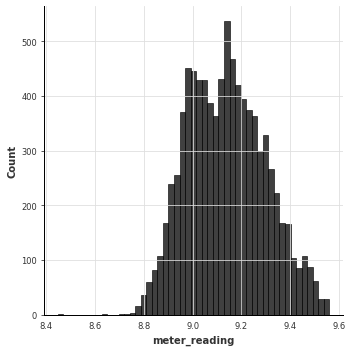

In [182]:
import seaborn as sns
sns.displot(np.log1p(raw_data['meter_reading']))

In [183]:
ts_data = TimeSeries.from_dataframe(raw_data, time_col='timestamp', value_cols=value_cols)

In [184]:
ts_data = ts_data.add_holidays('US')
ts_data = ts_data.add_datetime_attribute('hour', cyclic=True)
ts_data = ts_data.add_datetime_attribute('month', one_hot=True)
ts_data = ts_data.add_datetime_attribute('dayofweek', cyclic=True)
ts_data = ts_data.add_datetime_attribute('dayofyear', cyclic=True)

In [185]:
px.line(raw_data, x='timestamp', y=['meter_reading'])

In [186]:
px.line(raw_data, x='timestamp', y=['meter_reading'])

In [187]:
load_std = np.std(ts_data['meter_reading'])
load_std

component
meter_reading    1519.955035
dtype: float64

In [188]:
load_mean = np.mean(ts_data['meter_reading'])
load_mean

component
meter_reading    9411.852127
dtype: float64

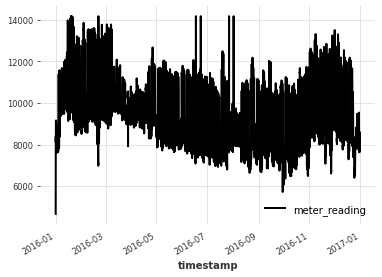

In [189]:
ts_data['meter_reading'].plot()

In [190]:
raw_data.head()

,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,sea_level_pressure,wind_direction,wind_speed,rolling mean,rolling std,diff,0,8,23,31,46
0,2016-01-01 00:00:00,4659.503945,3.8,0.0,2.4,1020.9,240.0,3.1,0.0000,0.000000,0.0000,4154.2543,-0.064614,3.8,0.062915,0.0
1,2016-01-01 01:00:00,8337.269600,3.7,0.0,2.4,1021.6,230.0,2.6,4154.2543,0.000000,0.0000,8337.2696,-0.272809,3.7,0.062915,0.0
2,2016-01-01 02:00:00,8317.915800,2.6,0.0,1.9,1021.9,0.0,0.0,12491.5239,0.000000,4183.0153,8317.9158,-0.272809,2.6,0.295657,0.0
3,2016-01-01 03:00:00,8392.468000,2.0,0.0,1.2,1022.3,170.0,1.5,20809.4397,2091.507650,-19.3538,8392.4680,-0.272809,2.0,0.295657,0.0
4,2016-01-01 04:00:00,8109.911700,2.3,0.0,1.8,1022.7,110.0,1.5,29201.9077,1967.346455,74.5522,8109.9117,-0.272809,2.3,0.295657,0.0


In [191]:
target_col = ['meter_reading']
cov_cols = list(ts_data.columns.drop(target_col))

In [192]:
train, test = ts_data.split_after(0.85)

train_target = train[target_col]
train_cov = train[cov_cols]

test_target = test[target_col]
test_cov = test[cov_cols]


In [206]:
lgb_model = LightGBMModel(
    max_bin=5000,
    max_depth=12,
    lags=24*7,
    lags_past_covariates=24*14,
    n_iter = 750,
    metric='rmse',
    early_stopping_rounds=30,
    learning_rate=0.01,
    zero_as_missing=True)

In [207]:
lgb_model.fit(train_target, past_covariates=train_cov, verbose=True, val_series=test_target,val_past_covariates=train_cov.append(test_cov))

/Users/sharabhshuklaair/opt/anaconda3/envs/armts/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning:

Found `n_iter` in params. Will use it instead of argument

/Users/sharabhshuklaair/opt/anaconda3/envs/armts/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=750, n_iter=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30


/Users/sharabhshuklaair/opt/anaconda3/envs/armts/lib/python3.9/site-packages/lightgbm/basic.py:154: UserWarning:

Converting column-vector to 1d array



[1]	valid_0's rmse: 1598.93
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 1583.91
[3]	valid_0's rmse: 1568.67
[4]	valid_0's rmse: 1553.89
[5]	valid_0's rmse: 1538.68
[6]	valid_0's rmse: 1523.72
[7]	valid_0's rmse: 1509.51
[8]	valid_0's rmse: 1494.49
[9]	valid_0's rmse: 1480.1
[10]	valid_0's rmse: 1465.36
[11]	valid_0's rmse: 1451.21
[12]	valid_0's rmse: 1437.78
[13]	valid_0's rmse: 1423.94
[14]	valid_0's rmse: 1410.66
[15]	valid_0's rmse: 1396.79
[16]	valid_0's rmse: 1383.67
[17]	valid_0's rmse: 1370.14
[18]	valid_0's rmse: 1357.11
[19]	valid_0's rmse: 1344.54
[20]	valid_0's rmse: 1331.34
[21]	valid_0's rmse: 1319.15
[22]	valid_0's rmse: 1306.43
[23]	valid_0's rmse: 1294.32
[24]	valid_0's rmse: 1281.95
[25]	valid_0's rmse: 1270.04
[26]	valid_0's rmse: 1257.69
[27]	valid_0's rmse: 1246.15
[28]	valid_0's rmse: 1234
[29]	valid_0's rmse: 1222.56
[30]	valid_0's rmse: 1210.61
[31]	valid_0's rmse: 1199.53
[32]	valid_0's rmse: 1188.03
[33]	valid_0's rmse: 117

In [208]:
import pickle
pickle.dump(lgb_model, open('lgb_model_tsfresh_feat.pkl', 'wb'))

In [209]:
pred = lgb_model.predict(series=train_target, n=len(test_target), past_covariates=train_cov.append(test_cov))

In [210]:
from darts.metrics.metrics import r2_score, smape, rmsle, rmse

In [211]:
smape(test_target, pred)

3.01653596208705

In [212]:
rmse(test_target, pred)

370.3174762135164

In [213]:
rmsle(test_target, pred)

0.04109611511269547

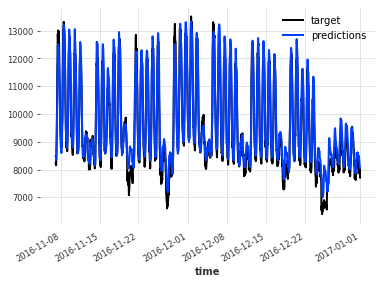

In [214]:
test_target.plot(label='target')
pred.plot(label='predictions')

In [215]:
pred_df = pd.DataFrame({'target': test_target.all_values().reshape(len(test_target)), 'prediction': pred.all_values().reshape(len(test_target))}, index=test_target.time_index)

In [216]:
px.line(pred_df, x=pred_df.index, y=['target', 'prediction'])

In [217]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import norm

fig = make_subplots(rows=3, shared_xaxes=True)

In [205]:
fig.add_trace(go.Scatter(x=pred.time_index, y=pred.all_values().reshape(len(test_target))), row=1, col=1)
fig.add_trace(go.Scatter(x=test_target.time_index, y=test_target.all_values().reshape(len(test_target))), row=1, col=1)